In [36]:
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../../')
from helpers.window import window_input_output

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Import data

In [38]:
df = pd.read_csv('../../datasets/Organic.csv')
df.head()

,Date,Envi,Fuji,Gala
0,2015-01-04,3199,6917,8
1,2015-01-11,8856,15071,25
2,2015-01-18,5475,32539,42
3,2015-01-25,4271,8412,585
4,2015-02-01,4824,10710,104


## Windows shift 26 columns

In [39]:
data = df[['Fuji']]

## ข้อมูลเบ้ขวา

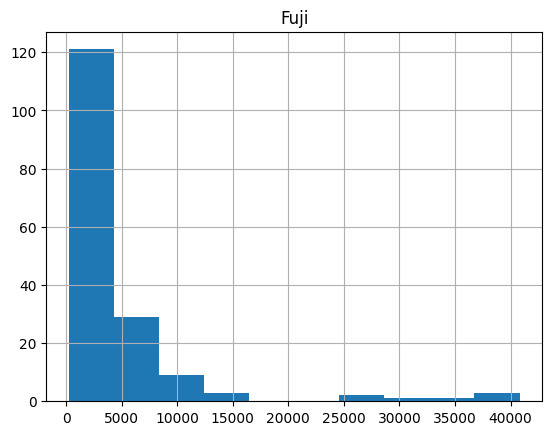

In [40]:
data.hist();

## Log transform

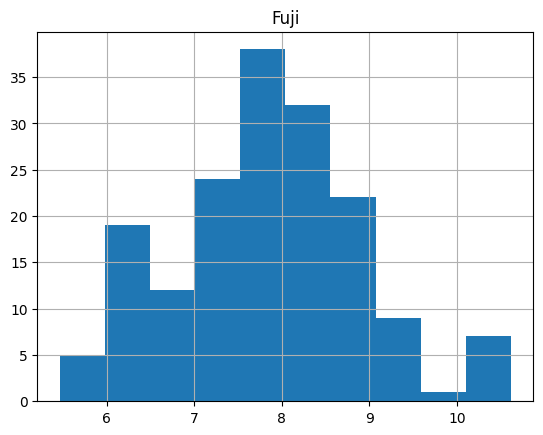

In [41]:
data = data.transform(np.log)
data.hist();

In [42]:
seq_df = window_input_output(26, 26, data)
seq_df.head()

,Fuji,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24,y_25
51,7.956477,8.090096,8.056744,8.994669,9.368625,8.653296,8.118505,9.140561,8.744647,8.751633,...,10.171834,9.363061,8.713089,8.862484,8.878358,9.278933,9.037415,10.390195,9.620528,8.841737
52,8.352554,7.956477,8.090096,8.056744,8.994669,9.368625,8.653296,8.118505,9.140561,8.744647,...,10.222196,10.171834,9.363061,8.713089,8.862484,8.878358,9.278933,9.037415,10.390195,9.620528
53,9.285912,8.352554,7.956477,8.090096,8.056744,8.994669,9.368625,8.653296,8.118505,9.140561,...,8.991562,10.222196,10.171834,9.363061,8.713089,8.862484,8.878358,9.278933,9.037415,10.390195
54,8.207947,9.285912,8.352554,7.956477,8.090096,8.056744,8.994669,9.368625,8.653296,8.118505,...,9.029298,8.991562,10.222196,10.171834,9.363061,8.713089,8.862484,8.878358,9.278933,9.037415
55,8.525161,8.207947,9.285912,8.352554,7.956477,8.090096,8.056744,8.994669,9.368625,8.653296,...,8.799812,9.029298,8.991562,10.222196,10.171834,9.363061,8.713089,8.862484,8.878358,9.278933


In [43]:
seq_df.shape

(118, 52)

## Split data

In [44]:
X_cols = [col for col in seq_df.columns if col.startswith('x')]
X_cols.insert(0, 'Fuji')
y_cols = [col for col in seq_df.columns if col.startswith('y')]

X = seq_df[X_cols]
y = seq_df[y_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=123)

In [45]:
eNet = ElasticNet()

params = {
                'alpha'     : [0.01, 0.1, 0.001, 1],
                'l1_ratio'  : np.arange(0.40,1.00,0.10),
                'tol'       : [0.0001, 0.001, 0.01, 0.1]
            }

gs = GridSearchCV(eNet, param_grid=params, scoring='roc_auc', cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

model = gs.best_estimator_

y_pred = model.predict(X_test)

print(model)

ElasticNet(alpha=0.01, l1_ratio=0.4)


## Score 

In [46]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (Fuji):", mse)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (Fuji):", mae)

print("R-squared (Test score)", model.score(X_test, y_test))
print("Train score", model.score(X_train, y_train))

Mean Squared Error (Fuji): 0.5719105145027211
Mean Absolute Error (Fuji): 0.5882450399671788
R-squared (Test score) -0.752703315111355
Train score 0.33131191646496355


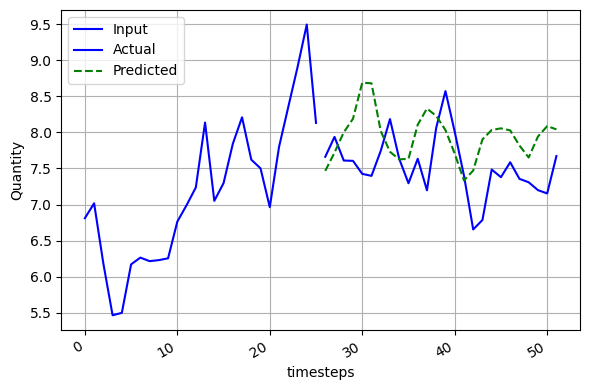

In [47]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(np.arange(0, 26, 1), X_test.iloc[1, ], 'b-', label='Input')
ax.plot(np.arange(26, 52, 1), y_test.iloc[1, ], color='blue', label='Actual')
ax.plot(np.arange(26, 52, 1), y_pred[1], color='green', label='Predicted', linestyle='--')

ax.set_xlabel('timesteps')
ax.set_ylabel('Quantity')
plt.grid(True)
plt.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

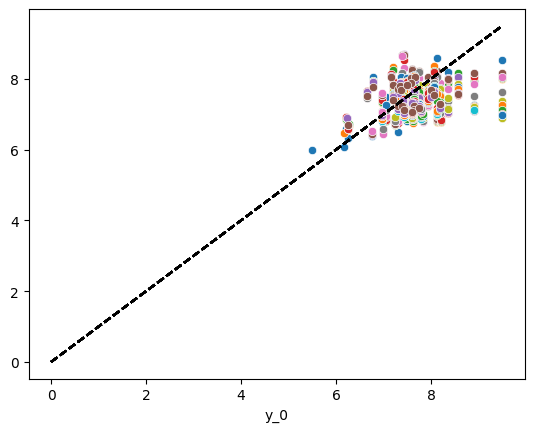

In [48]:
for i, col in enumerate(y_test.columns):
    sns.scatterplot(x=y_test[col], y=y_pred[:, i])

    max_val = max(y_test.max().max(), y_pred.max().max())
    plt.plot([0, max_val], [0, max_val], color='black', linestyle='--')